### （1）将所有分类变量做哑编码；
###  （3）剔除方差为零的变量；
###  （4）删除所有calc组内变量
### （5）将所有特征合并，训练lgb模型

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomTreesEmbedding
import xgboost as xgb
from sklearn import metrics
import lightgbm as lgb
from copy import deepcopy
from sklearn.externals import joblib
from sklearn.preprocessing import OneHotEncoder
import graphviz
import win32com.client  
import winsound  
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_path=r'D:\study\Competition\porto-sequro-safe-driver-prediction\data'
train_df=pd.read_csv(data_path+'\\train.csv',na_values=-1)
test_df=pd.read_csv(data_path+'\\test.csv',na_values=-1)

In [3]:
#所有变量
raw_features=[x for x in train_df.columns if x not in ['id','target']]
#所有二元变量
bin_features=[feat for feat in train_df.columns if 'bin' in feat]
#所有的分类变量
cat_features=[feat for feat in train_df.columns if 'cat' in feat]
#所有calc变量
calc_features=[feat for feat in train_df.columns if 'calc' in feat]

### 删除所有calc组内变量

In [4]:
train_df.drop(calc_features,axis=1,inplace=True)
test_df.drop(calc_features,axis=1,inplace=True)

In [5]:
raw_features=[x for x in train_df.columns if x not in ['id','target']]

In [6]:
train_df.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,1.0,0,0.0,1,12,2.0,0.400000,0.883679,0.370810,3.605551
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,1.0,1,2.0,1,19,3.0,0.316228,0.618817,0.388716,2.449490
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,1.0,1,2.0,1,60,1.0,0.316228,0.641586,0.347275,3.316625


### One_Hot_Encoding

In [7]:
def get_dummy_feat(train_df,test_df,cat_features):
    oht_feat=pd.get_dummies(train_df[cat_features].append(test_df[cat_features]),columns=cat_features,dummy_na=True)
    train_df=train_df.join(oht_feat.iloc[0:train_df.shape[0]])
    test_df=test_df.join(oht_feat.iloc[train_df.shape[0]:])
    return train_df,test_df

In [8]:
train_df,test_df=get_dummy_feat(train_df,test_df,cat_features)

### 方差为0（或取值唯一）的变量

In [9]:
useless_feats=list(train_df.columns[train_df.var()==0])

In [10]:
use_features=[x for x in train_df.columns if x not in ['id','target']+cat_features+useless_feats]

In [11]:
X=train_df[use_features]
y=train_df['target']

X_predict=test_df[use_features]

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,stratify=y,random_state=9)

# 1 Base line

In [15]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

def gini_normalized(preds,dtrain):
    y=dtrain.get_label()
    preds=softmax(preds)
    return 'NormGini',gini(y, preds) / gini(y, y),True

def gini_normalized_ordinary(y,preds):
    return gini(y, preds) / gini(y, y)

def modelfit(alg,X,y,X_test,y_test,cat_features,cvparams,folds=None,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    feature_names=list(X.columns)
    if useTrainCV==True:
        dtrain=lgb.Dataset(X, label=y, max_bin=255, reference=None, 
                           weight=None, group=None, silent=False, feature_name=feature_names,
                            categorical_feature=cat_features,params=None, free_raw_data=True)
        cvresult=lgb.cv(cvparams,dtrain,num_boost_round=50000,folds=folds,nfold=cv_folds,stratified=True,
                        metrics='auc',feature_name=feature_names,categorical_feature=cat_features,early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=20,show_stdv =True,seed=9)
        #,feval=gini_normalized
        alg.set_params(n_estimators=len(cvresult['auc-mean']))
        print('Best Iteration:',len(cvresult['auc-mean']))
        
    alg.fit(X,y,eval_metric='auc',feature_name=feature_names,categorical_feature=cat_features)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    dtrain_predprob=alg.predict_proba(X)[:,1]
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    dtest_predprob=alg.predict_proba(X_test)[:,1]
    
    #Print Mode report:
    print('Model report on trian:')
    #print('Train Accuracy:{0:.4f}'.format(metrics.accuracy_score(y,dtrain_predictions)))
    print('Train AUC:{0:.4f}'.format(metrics.roc_auc_score(y,dtrain_predprob)))
    #print('Train Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y,dtrain_predprob)))
    print('Model report on test:')
    #print('Test Accuracy:{0:.4f}'.format(metrics.accuracy_score(y_test,dtest_predictions)))
    print('Test AUC:{0:.4f}'.format(metrics.roc_auc_score(y_test,dtest_predprob)))
    #print('Test Normalized GINI：{0：.6f}'.format(gini_normalized_ordinary(y,dtest_predprob)))
    print('Test classifiction report:')
    print(metrics.classification_report(y_test,dtest_predictions))
    print('Test confusion matrix:')
    plt.figure()
    with sns.axes_style(style='dark'):
        plot_confusion_matrix(metrics.confusion_matrix(y_test,dtest_predictions),classes=['0','1'],
                             title='Confusion Matrix')
    
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    #plt.figure()
    #feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    #plt.ylabel('Feature Importance Score')
    lgb.plot_importance(alg,importance_type='split')
    return feat_imp

def turnParams(model,X,y,cat_features,searchParam,modelparams,scoring='roc_auc',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='auc',categorical_feature=cat_features)
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)
    speak = win32com.client.Dispatch('SAPI.SPVOICE')  
    winsound.Beep(20170, 800)  
    speak.Speak('程序运行完毕!')
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
params={'boosting_type':'gbdt',
        'num_leaves':50,
        'max_depth':20,
        'learning_rate':0.2,
        'n_estimators':100,
        'max_bin':255,
        'objective':'binary',
        'min_split_gain':0,
        'min_child_weight':0,
        'min_child_samples':1,
        'subsample':1.0,
        'subsample_freq':1,
        'colsample_bytree':1.0,
        'reg_alpha':0,
        'reg_lambda':0,
        'random_state':9,
        'n_jobs':4,
        'is_unbalance':True,
       }

cvparams={'boosting_type':'gbdt',
        'num_leaves':20,
        'max_depth':6,
        'learning_rate':0.2,
        'max_bin':255,
        'objective':'binary',
        'min_gain_to_split':0,
        'min_sum_hessian_in_leaf':0,
        'min_data_in_leaf':1,
        'bagging_fraction':1.0,
        'bagging_freq':1,
        'feature_fraction':1.0,
        'lambda_l1':0,
        'lambda_l2':0,
        'num_threads':4,
        'is_unbalance':True,
       }
#在sklaearn接口中，参数名称发生了变化，需要进行映射
tran_table={ 'min_split_gain':'min_gain_to_split',
             'min_child_weight':'min_sum_hessian_in_leaf',
             'min_child_samples':'min_data_in_leaf',
             'subsample':'bagging_fraction',
             'subsample_freq':'bagging_freq',
             'colsample_bytree':'feature_fraction',
             'reg_alpha':'lambda_l1',
             'reg_lambda':'lambda_l2',
             'n_jobs':'num_threads',
            
             'boosting_type':'boosting_type',
             'num_leaves':'num_leaves',
             'max_depth':'max_depth',
             'learning_rate':'learning_rate',
             'max_bin':'max_bin',
             'objective':'objective',
             'is_unbalance':'is_unbalance'}
def get_lgb_params(sklearn_params,cvparams,tran_table):
    for sklearn_param,lgb_param in tran_table.items():
        cvparams[lgb_param]=sklearn_params[sklearn_param]

In [17]:
lgbc=lgb.LGBMClassifier(**params)

[20]	cv_agg's auc: 0.633544 + 0.00387579
[40]	cv_agg's auc: 0.627646 + 0.00371555
[60]	cv_agg's auc: 0.622973 + 0.00363894
Best Iteration: 18
Model report on trian:
Train AUC:0.6824
Model report on test:
Test AUC:0.6356
Test classifiction report:
             precision    recall  f1-score   support

          0       0.97      0.64      0.77    114704
          1       0.05      0.55      0.10      4339

avg / total       0.94      0.63      0.74    119043

Test confusion matrix:
Confusion matrix, without normalization
[[72936 41768]
 [ 1951  2388]]


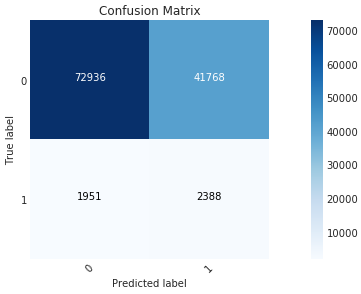

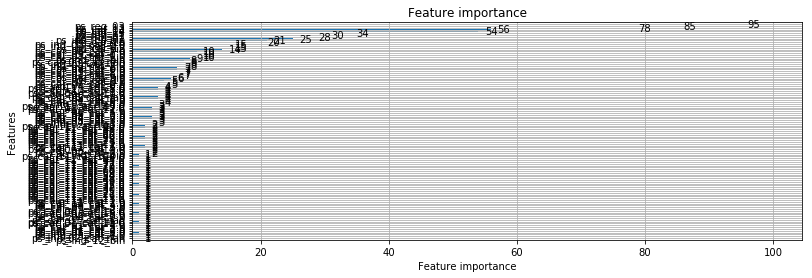

In [18]:
get_lgb_params(lgbc.get_params(),cvparams,tran_table)

feat_imp=modelfit(lgbc,X_train,y_train,X_test,y_test,'auto',cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=50)

In [19]:
params['n_estimators']=18

# 2 Tune params

In [20]:
#不重要的警告信息不予显示
import warnings
warnings.filterwarnings("ignore")

## 2.1 subsample

In [21]:
searchParam={'subsample':[0.95,0.96,0.97,0.98,0.99,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
subsample : 1.0
Best score: 0.634458424815
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.95         0.632901          0.690092        0.005243         0.000808
0.96         0.633659          0.689744        0.004854         0.001511
0.97         0.633506          0.689890        0.004247         0.001209
0.98         0.632630          0.690364        0.005006         0.001187
0.99         0.634280          0.689802        0.004710         0.001412
1.00         0.634458          0.690993        0.004603         0.000739


## 2.3 colsample_bytree

In [22]:
searchParam={'colsample_bytree':[0.1,0.3,0.5,0.7,0.9,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
colsample_bytree : 0.7
Best score: 0.635274292364
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.1         0.623212          0.654760        0.004008         0.001035
0.3         0.630613          0.678089        0.004301         0.001275
0.5         0.633833          0.684757        0.004595         0.001194
0.7         0.635274          0.686527        0.004187         0.000932
0.9         0.634752          0.689611        0.006136         0.000954
1.0         0.634458          0.690993        0.004603         0.000739


In [23]:
searchParam={'colsample_bytree':[0.55,0.6,0.65,0.7,0.75,0.8,0.85]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
colsample_bytree : 0.8
Best score: 0.635860533441
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.55         0.635278          0.684818        0.004731         0.001522
0.60         0.634656          0.685800        0.004326         0.000774
0.65         0.635012          0.685914        0.005657         0.001493
0.70         0.635274          0.686527        0.004187         0.000932
0.75         0.634870          0.687312        0.005049         0.000953
0.80         0.635861          0.688163        0.005502         0.000667
0.85         0.634785          0.688805        0.004671         0.000931


In [24]:
searchParam={'colsample_bytree':[0.77,0.79,0.8,0.81,0.83]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
colsample_bytree : 0.8
Best score: 0.635860533441
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.77         0.634233          0.687142        0.003522         0.001433
0.79         0.634659          0.687753        0.005411         0.001258
0.80         0.635861          0.688163        0.005502         0.000667
0.81         0.634651          0.687925        0.005519         0.001224
0.83         0.634613          0.688230        0.005320         0.000757


## 2.4 reg_alpha

In [25]:
searchParam={'reg_alpha':[35,37,39,41,43]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 41
Best score: 0.637083824402
    mean_test_score  mean_train_score  std_test_score  std_train_score
35         0.636103          0.681553        0.005656         0.001089
37         0.635116          0.680363        0.004396         0.001590
39         0.636362          0.680068        0.004651         0.001356
41         0.637084          0.680244        0.005416         0.001485
43         0.636900          0.680006        0.005728         0.001334


In [26]:
searchParam={'reg_alpha':[40,40.5,41,41.5,42]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 40.5
Best score: 0.637380646954
      mean_test_score  mean_train_score  std_test_score  std_train_score
40.0         0.636821          0.680062        0.005076         0.001438
40.5         0.637381          0.680394        0.004867         0.001130
41.0         0.637084          0.680244        0.005416         0.001485
41.5         0.636648          0.680052        0.005082         0.001289
42.0         0.637094          0.680226        0.005501         0.001370


In [27]:
searchParam={'reg_alpha':[40.2,40.3,40.4,40.5,40.6]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 40.6
Best score: 0.6375699274
      mean_test_score  mean_train_score  std_test_score  std_train_score
40.2         0.637395          0.680378        0.004766         0.001420
40.3         0.637465          0.680424        0.004875         0.001315
40.4         0.637532          0.680522        0.004910         0.001293
40.5         0.637381          0.680394        0.004867         0.001130
40.6         0.637570          0.680169        0.005165         0.001465


In [29]:
searchParam={'reg_alpha':[40.55,40.59,40.6,40.61,40.65]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 40.59
Best score: 0.637602094742
       mean_test_score  mean_train_score  std_test_score  std_train_score
40.55         0.637381          0.680390        0.004867         0.001130
40.59         0.637602          0.680160        0.005157         0.001459
40.60         0.637570          0.680169        0.005165         0.001465
40.61         0.637546          0.679990        0.005170         0.001491
40.65         0.637548          0.679983        0.005169         0.001488


In [31]:
searchParam={'reg_alpha':[40.589,40.59,40.591]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 40.589
Best score: 0.637602102905
        mean_test_score  mean_train_score  std_test_score  std_train_score
40.589         0.637602           0.68016        0.005157         0.001459
40.590         0.637602           0.68016        0.005157         0.001459
40.591         0.637602           0.68016        0.005157         0.001459


## 2.5 reg_lambda

In [35]:
searchParam={'reg_lambda':[0,1e-5,1e-3,0.01,0.05,0.1,0.15]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 0.05
Best score: 0.637602306982
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         0.637602          0.680160        0.005157         0.001459
0.00001         0.637602          0.680160        0.005157         0.001459
0.00100         0.637602          0.680160        0.005157         0.001459
0.01000         0.637602          0.680160        0.005157         0.001459
0.05000         0.637602          0.680159        0.005157         0.001459
0.10000         0.637579          0.679978        0.005162         0.001485
0.15000         0.637591          0.679980        0.005147         0.001489


In [36]:
searchParam={'reg_lambda':[0.03,0.04,0.05,0.06,0.07]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 0.06
Best score: 0.637602367263
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.03         0.637602          0.680160        0.005157         0.001459
0.04         0.637602          0.680159        0.005157         0.001459
0.05         0.637602          0.680159        0.005157         0.001459
0.06         0.637602          0.680159        0.005157         0.001459
0.07         0.637578          0.679979        0.005162         0.001485


## 2.6 min_child_samples

In [37]:
searchParam={'min_child_samples':[1,2,3,4,5,6,7]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_samples : 3
Best score: 0.63785259946
   mean_test_score  mean_train_score  std_test_score  std_train_score
1         0.637602          0.680159        0.005157         0.001459
2         0.637602          0.680159        0.005157         0.001459
3         0.637853          0.680159        0.005134         0.001459
4         0.637853          0.680159        0.005134         0.001459
5         0.637853          0.680159        0.005134         0.001459
6         0.637853          0.680159        0.005134         0.001459
7         0.637853          0.680159        0.005134         0.001459


## 2.7 min_child_weight

In [39]:
searchParam={'min_child_weight':[0,1e-5,1e-3,0.1,0.5,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_weight : 0
Best score: 0.63785259946
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         0.637853          0.680159        0.005134         0.001459
0.00001         0.637853          0.680159        0.005134         0.001459
0.00100         0.637853          0.680159        0.005134         0.001459
0.10000         0.637853          0.680159        0.005134         0.001459
0.50000         0.637853          0.680159        0.005134         0.001459
1.00000         0.637853          0.680159        0.005134         0.001459


## 2.9 min_split_gain

In [40]:
searchParam={'min_split_gain':[0,1e-5,1e-4,1e-3,1e-2]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_split_gain : 0
Best score: 0.63785259946
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         0.637853          0.680159        0.005134         0.001459
0.00001         0.637853          0.680159        0.005134         0.001459
0.00010         0.637853          0.680159        0.005134         0.001459
0.00100         0.637853          0.680159        0.005134         0.001459
0.01000         0.637309          0.680452        0.004789         0.001078


## 2.10 num_leaves

In [41]:
searchParam={'num_leaves':[46,48,49,50,51,52,53]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 50
Best score: 0.63785259946
    mean_test_score  mean_train_score  std_test_score  std_train_score
46         0.636357          0.677670        0.005211         0.000894
48         0.635743          0.679114        0.005754         0.001218
49         0.636275          0.679558        0.005049         0.001649
50         0.637853          0.680159        0.005134         0.001459
51         0.636501          0.680989        0.005069         0.001552
52         0.637448          0.682444        0.004968         0.001668
53         0.636737          0.682569        0.005075         0.001400


## 2.10 max_depth

In [44]:
searchParam={'max_depth':[16,17,18]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_depth : 17
Best score: 0.63785259946
    mean_test_score  mean_train_score  std_test_score  std_train_score
16         0.637736          0.680181        0.005237         0.001497
17         0.637853          0.680159        0.005134         0.001459
18         0.637853          0.680159        0.005134         0.001459


## 2.11 lower learning_rate

[20]	cv_agg's auc: 0.626005 + 0.00415644
[40]	cv_agg's auc: 0.627384 + 0.00415079
[60]	cv_agg's auc: 0.628913 + 0.0042198
[80]	cv_agg's auc: 0.630601 + 0.0044568
[100]	cv_agg's auc: 0.631912 + 0.00454011
[120]	cv_agg's auc: 0.632912 + 0.00446697
[140]	cv_agg's auc: 0.633905 + 0.004645
[160]	cv_agg's auc: 0.634567 + 0.00472358
[180]	cv_agg's auc: 0.635256 + 0.00482158
[200]	cv_agg's auc: 0.636122 + 0.00474767
[220]	cv_agg's auc: 0.636882 + 0.00472837
[240]	cv_agg's auc: 0.637639 + 0.00470437
[260]	cv_agg's auc: 0.638259 + 0.00468218
[280]	cv_agg's auc: 0.638751 + 0.00461352
[300]	cv_agg's auc: 0.639203 + 0.00458848
[320]	cv_agg's auc: 0.639686 + 0.0045999
[340]	cv_agg's auc: 0.640103 + 0.00463148
[360]	cv_agg's auc: 0.640472 + 0.00460994
[380]	cv_agg's auc: 0.640777 + 0.00462788
[400]	cv_agg's auc: 0.641027 + 0.00454357
[420]	cv_agg's auc: 0.641191 + 0.00451673
[440]	cv_agg's auc: 0.6413 + 0.00447769
[460]	cv_agg's auc: 0.641393 + 0.00446038
[480]	cv_agg's auc: 0.641433 + 0.00439355
[50

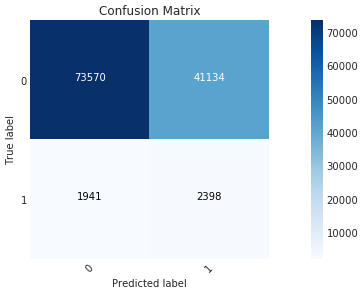

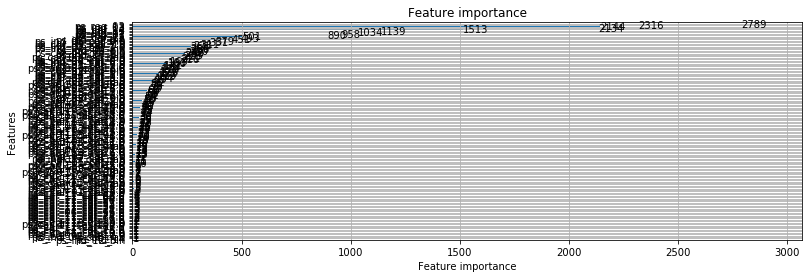

In [45]:
params['learning_rate']=0.01
lgbc=lgb.LGBMClassifier(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbc,X_train,y_train,X_test,y_test,'auto',cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=50)

In [48]:
params['n_estimators']=494

# 3 Final model

In [49]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'is_unbalance': True,
 'learning_rate': 0.01,
 'max_bin': 255,
 'max_depth': 17,
 'min_child_samples': 3,
 'min_child_weight': 0,
 'min_split_gain': 0,
 'n_estimators': 494,
 'n_jobs': 4,
 'num_leaves': 50,
 'objective': 'binary',
 'random_state': 9,
 'reg_alpha': 40.589,
 'reg_lambda': 0.06,
 'subsample': 1.0,
 'subsample_freq': 1}

In [50]:
lgbc_opt=lgb.LGBMClassifier(**params)

### cv

In [51]:
searchParam={'n_estimators':[494]}
turnParams(lgbc_opt,X,y,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
n_estimators : 494
Best score: 0.642025348528
     mean_test_score  mean_train_score  std_test_score  std_train_score
494         0.642025          0.688985        0.003235          0.00083


In [52]:
lgbc_opt.fit(X,y,feature_name=list(X.columns),categorical_feature='auto')

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.8, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=17, min_child_samples=3,
        min_child_weight=0, min_split_gain=0, n_estimators=494, n_jobs=4,
        num_leaves=50, objective='binary', random_state=9,
        reg_alpha=40.589, reg_lambda=0.06, silent=True, subsample=1.0,
        subsample_for_bin=50000, subsample_freq=1)

In [53]:
joblib.dump(lgbc_opt,r'D:\study\Competition\kaggle-PSSDP-20171014\20171107_19LightGBM_dummy_del_calc.pkl')

['D:\\study\\Competition\\kaggle-PSSDP-20171014\\20171107_19LightGBM_dummy_del_calc.pkl']

In [54]:
pred_prob=lgbc_opt.predict_proba(X_predict)[:,1]

In [55]:
predict_result=pd.DataFrame({'id':test_df['id'].astype(int),'target':pd.Series(pred_prob,index=test_df['id'].index)})

In [56]:
predict_result.head()

,id,target
0,0,0.430194
1,1,0.380775
2,2,0.415831
3,3,0.264990
4,4,0.499907


In [57]:
predict_result.to_csv(r'D:\study\Competition\kaggle-PSSDP-20171014\20171107_19LightGBM_dummy_del_calc.csv',index=False)

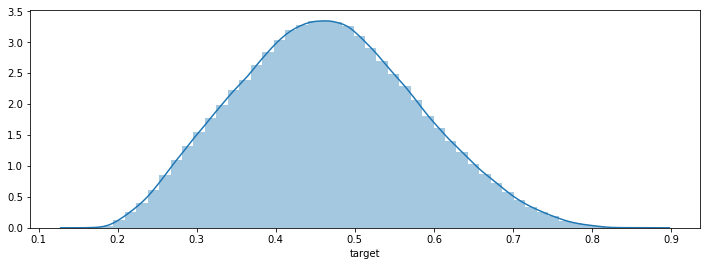

In [58]:
sns.distplot(predict_result['target'])

In [59]:
predict_result['target'].describe()

count    892816.000000
mean          0.465142
std           0.113737
min           0.151309
25%           0.382845
50%           0.462086
75%           0.543253
max           0.874331
Name: target, dtype: float64